### Load Data

Load raw data

In [4]:
import numpy as np
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'data'

sessions = np.array([])
for file in sorted(DATA_DIR.glob("steinmetz_part*.npz")):
    print(f"Loading {file}...")
    session = np.load(DATA_DIR / file, allow_pickle=True)
    sessions = np.hstack((sessions, session['dat']))

Loading D:\PractiseDirectory\nma2020-steinmetz-project\data\steinmetz_part0.npz...
Loading D:\PractiseDirectory\nma2020-steinmetz-project\data\steinmetz_part1.npz...
Loading D:\PractiseDirectory\nma2020-steinmetz-project\data\steinmetz_part2.npz...


### helper fuctions for trajectory

In [74]:
from sklearn.manifold import TSNE

def fit_tsne(X):
    
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020) 
    embed = tsne_model.fit_transform(X)
    
    return embed


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

plt.style.use('fivethirtyeight')

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def traj_viz_continous(x, y, axis, name_x = 'PC 1', name_y = 'PC 2', title = 'Neural Trajectory'):
  """
  Visualize neural trajectories with continous color coding
  
  Use np.take_along_axis with spike data and returned indices
  
  Arguments:
  x -- N x 1 array of data to be plotted along the x axis
  y -- N x 1 array of data to be plotted along the y axis. 
  axis -- the axis (of subplots) to draw the figure 

  Keyword Arguments:
  name_x -- label for x axis
  name_y -- label for y axis
  title -- title
  """

  dat_len = len(x)
  t = np.arange(0, dat_len)
  col_precision = 2 # color precision: num of points that is assigned to the same color
  
  # Create a set of line segments so that we can color them individually
  points = np.array([x, y]).T.reshape(-1, 1, 2)   # reshape into  numlines x points per line x 2 (x and y)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  # Create the line collection object, setting the colormapping parameters.
  # Have to set the actual values used for colormapping separately.
  lc = LineCollection(segments, cmap=plt.get_cmap('coolwarm'),
      norm=plt.Normalize(0, dat_len/col_precision))
  lc.set_array(t)
  lc.set_linewidth(3)

  # plot the line
  axis.add_collection(lc)

  # make it a little nicer
  axis.set_xlim( np.min(x) - np.std(x)/2 , np.max(x) + np.std(x)/2 )
  axis.set_xlabel(f'{name_x}')
  axis.set_ylim( np.min(y) - np.std(y)/2 , np.max(y) + np.std(y)/2 )
  axis.set_ylabel(f'{name_y}')
  axis.set_title(f'{title}')

  axis.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm 

def add_colorbar(axis, data_len):
    axins = inset_axes(axis,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axis.transAxes,
                   borderpad=0,
                   )
    cbar = plt.colorbar( cm.ScalarMappable(norm=plt.Normalize(0, data_len), cmap='coolwarm'), 
              ax=axis, 
              cax=axins
            )
    cbar.ax.set_ylabel(' Time (ms)')
    
def update_limits(pc_xlim, pc_ylim, xs, ys):
    pc_ylim[0] = ys[0] if pc_ylim[0] > ys[0] else pc_ylim[0]
    pc_ylim[1] = ys[1] if pc_ylim[1] < ys[1] else pc_ylim[1]
    pc_xlim[0] = xs[0] if pc_xlim[0] > xs[0] else pc_xlim[0]
    pc_xlim[1] = xs[1] if pc_xlim[1] < xs[1] else pc_xlim[1]
    
    return pc_xlim, pc_ylim


In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def traj_viz_discrete(x, y, idx_1, idx_2, name_x = 'PC 1', name_y = 'PC 2'):
  """
  Visualize neural trajectories with discrete color coding 
  based on specified indices
  
  Use np.take_along_axis with spike data and returned indices
  
  Arguments:
  x -- N x 1 array of data to be plotted along the x axis
  y -- N x 1 array of data to be plotted along the y axis
  idx_1 -- index position of the first color change. e.g. stimulus onset
  idx_2 -- index position of the first color change. e.g. action onset

  Keyword Arguments:
  name_x -- label for x axis
  name_y -- label for y axis
  """
  # 3rd variable for the color
  z = np.arange(0, len(x))

  plt.figure(figsize=(6, 6))

  # Create a colormap for red, green and blue and a norm to color
  # f' < idx_1 red, f' > idx2 blue, and the rest green
  cmap = ListedColormap(['r', 'g', 'b'])
  norm = BoundaryNorm([0, idx_1, idx_2, len(x)], cmap.N)

  # reshape to be numlines x points per line x 2 (x and y)
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  # Create the line collection object, setting the colormapping parameters.
  # Have to set the actual values used for colormapping separately.
  lc = LineCollection(segments, cmap=cmap, norm=norm)
  lc.set_array(z)
  lc.set_linewidth(3)
  plt.gca().add_collection(lc)

  plt.xlim( np.min(x) - np.std(x)/2 , np.max(x) + np.std(x)/2 )
  plt.xlabel(f'{name_x}')
  plt.ylim( np.min(y) - np.std(y)/2 , np.max(y) + np.std(y)/2 )
  plt.ylabel(f'{name_y}')
  plt.title('Trajectory Viz')

  # make it a little nicer
  plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False)
  ax = plt.gca()
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
#   plt.arrow(x[-1], y[-1], -(x[-2]-x[-1]), -(y[-2]-y[-1]),
#             width = 0.04, shape='full', lw=0, length_includes_head=True, 
#             head_width=.04, color='k')
  
x = pc1
y = pc2
idx_1 = len(x)/3
idx_2 = len(x)*2/3
traj_viz_discrete(x, y, idx_1, idx_2, name_x = 'PC 1', name_y = 'PC 2')

In [ ]:
import matplotlib.animation as animation


%matplotlib notebook
def traj_viz_anim(x, y, 
                  idx_1, idx_2, 
                  name_x = 'PC 1', name_y = 'PC 2', 
                  color_type='continuous'
                  ):
  """
  Visualize animated neural trajectories with continous or discrete color coding
  
  Use np.take_along_axis with spike data and returned indices
  
  Arguments:
  x -- N x 1 array of data to be plotted along the x axis
  y -- N x 1 array of data to be plotted along the y axis. 
  idx_1 -- index (along axis=0) position of the first color change. e.g. stimulus onset
  idx_2 -- index (along axis=0) position of the first color change. e.g. action onset

  Keyword Arguments:
  name_x -- label for x axis
  name_y -- label for y axis
  color_type -- 'discrete' or 'continuous'
  """

  # Create figure
  fig = plt.figure(figsize=(8, 8))
  ax = plt.gca()
    
  dat_len = len(x)

  # 3rd variable for the color
  t = np.arange(0, dat_len)

  # reshape to be numlines x points per line x 2 (x and y)
  points = np.array([x, y]).T.reshape(-1, 1, 2) # reshape into  numlines x points per line x 2 (x and y)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  if color_type=='continuous':
    col_precision = 2 # color precision: num of points that is assigned to the same color

    # Create the line collection object, setting the colormapping parameters.
    # Set values used for colormapping separately.
    line = LineCollection(segments, cmap=plt.get_cmap('coolwarm'),
    norm=plt.Normalize(0, dat_len/col_precision))
  elif color_type=='discrete':

    # Create a colormap for red, green and blue and a norm to color
    # f' < idx_1 red, f' > idx2 blue, and the rest green
    cmap = ListedColormap(['r', 'g', 'b'])
    norm = BoundaryNorm([0, idx_1, idx_2, len(x)], cmap.N)   

    # Create the line collection object, setting the colormapping parameters.
    # Have to set the actual values used for colormapping separately.
    line = LineCollection(segments, cmap=cmap, norm=norm)

  line.set_array(t)
  line.set_linewidth(3)

  # plot the line
  ax.add_collection(line)

  # initialization function: plot the background of each frame
  def init():
    line.set_segments([])
    return line,

  # animation function.  This is called sequentially
  def animate(i):
    segments_ani = segments[:i, :, :]
    line.set_segments(segments_ani)
    return line,

  # call the animator.  blit=True means only re-draw the parts that have changed.
  ani = animation.FuncAnimation(fig, animate, init_func=init,
                           frames=segments.shape[0], interval=10, blit=True)

  #figure style
  plt.xlim( np.min(x) - np.std(x)/2 , np.max(x) + np.std(x)/2 )
  plt.xlabel(f'{name_x}')
  plt.ylim( np.min(y) - np.std(y)/2 , np.max(y) + np.std(y)/2 )
  plt.ylabel(f'{name_y}')
  plt.title('Trajectory Viz')

  plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

  plt.draw()
  plt.show() 
  return ani

# this shows time trajectory over one whole trial
# anim.save('im.mp4') # if you want to save to mp form

#### Load selector data

In [5]:
with open(DATA_DIR / "selectors.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

Load decoder results from session 24.

Including both vision and action

In [6]:
import pickle

with open(DATA_DIR / "decoder_results.pickle", "rb") as f:
    dec_res = pickle.load(f)

In [8]:
# Key to this dictionary is 10 or 24 
print(dec_res[24].keys())
print(dec_res[24]['action'].keys())

dict_keys(['action', 'vision'])


#### get action decision times and vision decision times for common trials

In [16]:
action_trials = dec_res[24]['action']['trial_numbers']
action_times = dec_res[24]['action']['decision_times']

vision_trials = dec_res[24]['vision']['trial_numbers']
vision_times = dec_res[24]['vision']['decision_times']

# common trials for action and vision
common_trials = np.intersect1d(action_trials, vision_trials)

In [101]:
# for common trials
action_times_ = action_times[np.in1d(action_trials, common_trials)]
vision_times_ = vision_times[np.in1d(vision_trials, common_trials)]

avg_action_t = np.mean(action_times_)
avg_vision_t = np.mean(vision_times_)

In [100]:
avg_action_t, avg_vision_t

(257.14285714285717, 89.10714285714286)

In [108]:
vision_idx = 89+500
action_idx = 500+257

### Do PCA for neural trajectories

Visual areas

In [79]:
# run pca on visual region

# Choose
sub = 24
sel = selectors[sub]
vis_dat = sessions[sub]['spks'][sel["NEURON_VISUAL"]]

print(vis_dat.shape)

%run run_PCA.ipynb
%run smt_PCA.ipynb

W, V, variance_explained = run_pca(vis_dat[:,:,51:130])

# project data to pcs
pc_10ms = map_pca(W, V, vis_dat)

# get first two mean pcs and smooth them
n = 2500
pc_smt_ = np.zeros((pc_10ms.shape[0],n))

for i in range(pc_10ms.shape[0]):
    pc_smt = smt_pca(pc_10ms[i].mean(axis = 0),n)
    pc_smt_[i,:] = pc_smt

print(pc_10ms[0][1][51:].shape)

(94, 261, 250)
(199,)


In [73]:
def map_and_smooth(data, W, V):
    '''
        Map PCA weights to data and smooth
    '''
    # map pc
    pc_10ms = map_pca(W, V, data)

    # smooth the first two PC
    n = 2500
    pc_smt_ = np.zeros((pc_10ms.shape[0],n))    
    for i in range(pc_10ms.shape[0]):
        pc_smt = smt_pca(pc_10ms[i].mean(axis = 0),n)
        pc_smt_[i,:] = pc_smt
    
    return pc_smt_

In [82]:
# Map PCA for For vision
sel['CHOICE_INCORRECT'] = ~sel['CHOICE_CORRECT']
outcomes = ['CHOICE_CORRECT' , 'CHOICE_INCORRECT']

contrast_levels = ["STIM_RIGHT_HIGH", "STIM_RIGHT_MEDIUM", "STIM_RIGHT_LOW", "STIM_RIGHT_NONE"]

# create two dictionaries
pc_vision_correct = {}
pc_vision_incorrect = {}

embed_correct = {}
embed_incorrect = {}

for outcome in outcomes:
    # get smoothed pc components for each
    print(f'pc_vision_{outcome[7:]}'.lower())
    for contrast in contrast_levels:
        # select data
        contrast_data = vis_dat[:, sel[contrast] & sel[outcome]]
        
        # save pc in dictionary
        if outcome == 'CHOICE_CORRECT':
            pc_vision_correct[contrast] = map_and_smooth(contrast_data, W, V)
            embed_correct[contrast] = fit_tsne(pc_vision_correct[contrast])

        elif outcome == "CHOICE_INCORRECT":
            pc_vision_incorrect[contrast] = map_and_smooth(contrast_data, W, V)
            embed_incorrect[contrast] = fit_tsne(pc_vision_incorrect[contrast])
        
        print(outcome, contrast, 'shape: ', contrast_data.shape)


pc_vision_correct
CHOICE_CORRECT STIM_RIGHT_HIGH shape:  (94, 43, 250)
CHOICE_CORRECT STIM_RIGHT_MEDIUM shape:  (94, 32, 250)
CHOICE_CORRECT STIM_RIGHT_LOW shape:  (94, 15, 250)
CHOICE_CORRECT STIM_RIGHT_NONE shape:  (94, 91, 250)
pc_vision_incorrect
CHOICE_INCORRECT STIM_RIGHT_HIGH shape:  (94, 22, 250)
CHOICE_INCORRECT STIM_RIGHT_MEDIUM shape:  (94, 13, 250)
CHOICE_INCORRECT STIM_RIGHT_LOW shape:  (94, 11, 250)
CHOICE_INCORRECT STIM_RIGHT_NONE shape:  (94, 34, 250)


Vision Correct Trials


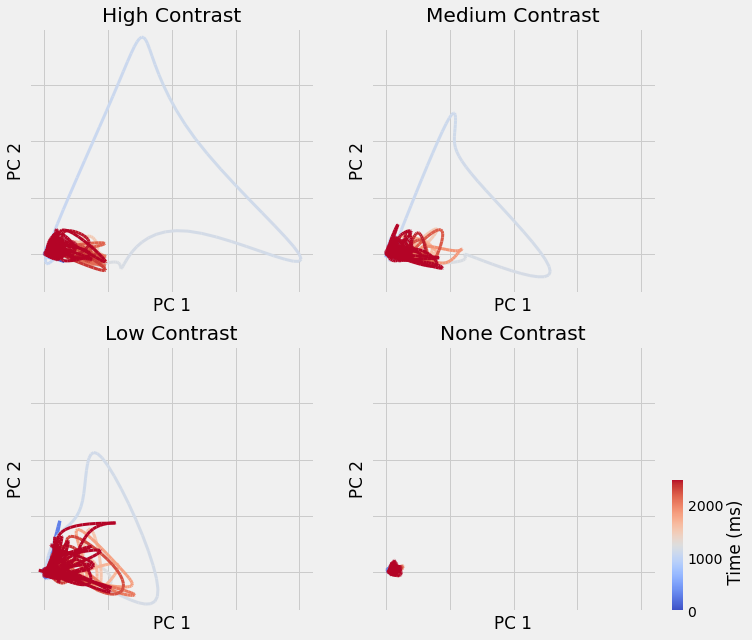

In [51]:
# Visualization for vision, correct
print('Vision Correct Trials')
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

pc_indicse = [0, 1]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(pc_vision_correct[contrast][pc_indicse[0]], pc_vision_correct[contrast][pc_indicse[1]], 
                       axs[i//2, i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_correct[contrast][0]))

Vision Incorrect Trials


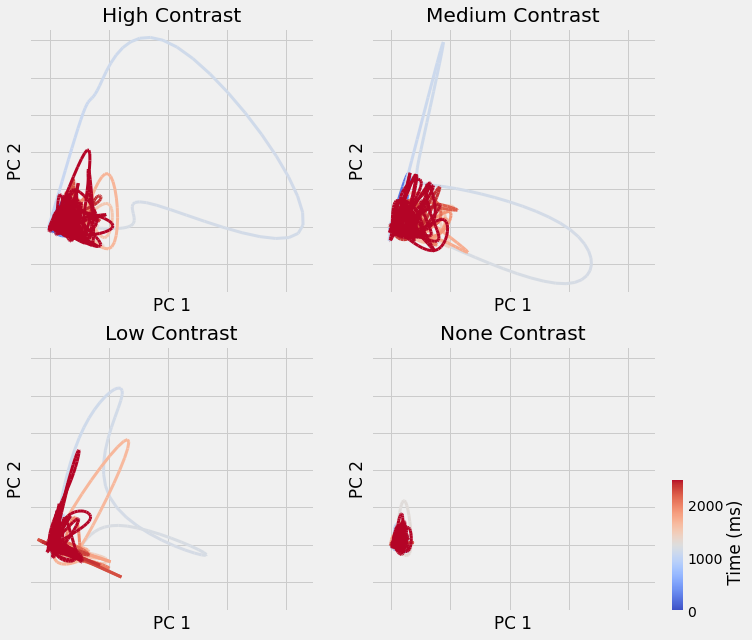

In [52]:
# Visualization for vision, incorrect
print('Vision Incorrect Trials')
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(pc_vision_incorrect[contrast][pc_indicse[0]], pc_vision_incorrect[contrast][pc_indicse[1]], 
                       axs[i//2, i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_incorrect[contrast][0]))

Using mean action decision time and mean vision decision time to color code trajectory.

In [116]:
, action_idx

(589, 757)

In [119]:
757/2500

0.3028

<IPython.core.display.Javascript object>


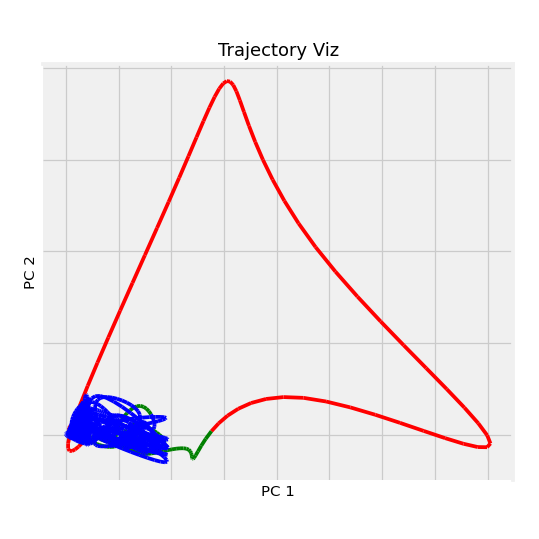

In [115]:
pc01 = pc_vision_correct['STIM_RIGHT_HIGH'][0][500:]
pc02 = pc_vision_correct['STIM_RIGHT_HIGH'][1][500:]
traj_viz_discrete(pc01, pc02, vision_idx - 500, action_idx - 500, name_x = 'PC 1', name_y = 'PC 2')

### Visualize 2D neural trajectories with color coding based on timing. (Pre-stim, pre-action, post-action)

<IPython.core.display.Javascript object>


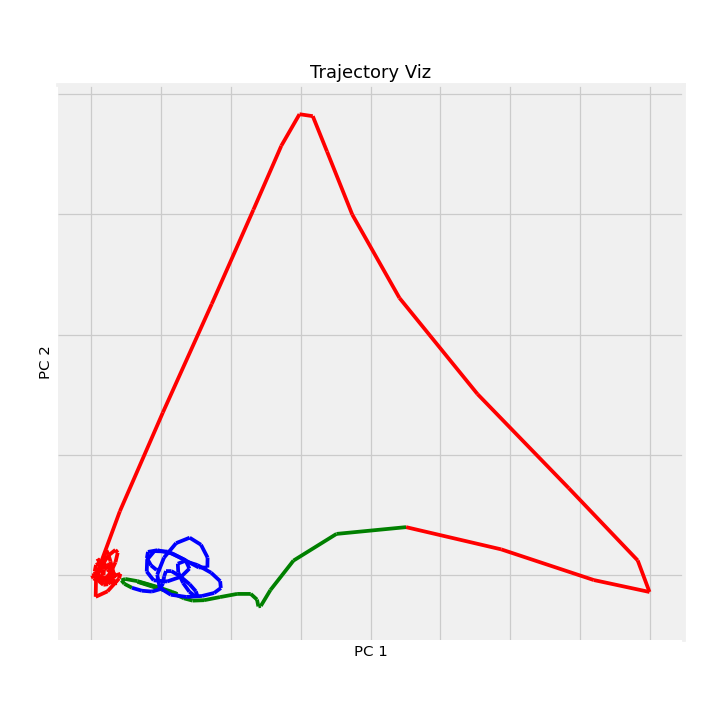

In [124]:
import math

pc1 = pc_vision_correct['STIM_RIGHT_HIGH'][0][300: 1500: 3]
pc2 = pc_vision_correct['STIM_RIGHT_HIGH'][1][300: 1500: 3]
anim=traj_viz_anim(pc1, pc2, math.floor(len(pc1)* vision_idx / 2500), math.floor(len(pc2)* action_idx / 2500), 
                   name_x = 'PC 1', name_y = 'PC 2', color_type='discrete')

Motor Areas

In [53]:
with open(DATA_DIR / "selectors_BW.npy", "rb") as f:
    selectors_B = np.load(f, allow_pickle=True)

sel_b = selectors_B[sub]

In [55]:
# run pca on secondary motor region
mot_dat = sessions[sub]['spks'][sel["NEURON_MOTOR"]]

print(mot_dat.shape)

W_m, V_m, variance_explained_m = run_pca(mot_dat[:,:,0:200])

# project data to pcs
pc_mot = map_pca(W_m, V_m, mot_dat)

# get first two mean pcs and smooth them
n = 2500
pc_m_smt_ = np.zeros((pc_mot.shape[0],n))

for i in range(pc_mot.shape[0]):
    pc_m_smt = smt_pca(pc_mot[i].mean(axis = 0),n)
    pc_m_smt_[i,:] = pc_m_smt

print(pc_mot[0][1][51:].shape)

(80, 261, 250)
(199,)


In [56]:
# Map PCA For motor
actions = ["GO_TRIALS", "NOGO_TRIALS"]

pc_motor_correct = {}
pc_motor_incorrect = {}

for outcome in outcomes:
    # get smoothed pc components for each
    print(f'pc_motor_{outcome[7:]}'.lower())

    for action in actions:
        # select data
        action_data = motor_dat[:, sel_b[action] & sel[outcome]]
        print(outcome, action, 'shape: ', action_data.shape)
        
        # save pc in dictionary
        if outcome == 'CHOICE_CORRECT':
            pc_motor_correct[action] = map_and_smooth(action_data, W_m, V_m)
        elif outcome == "CHOICE_INCORRECT":
            pc_motor_incorrect[action] = map_and_smooth(action_data, W_m, V_m)

pc_motor_correct
CHOICE_CORRECT GO_TRIALS shape:  (80, 161, 250)
CHOICE_CORRECT NOGO_TRIALS shape:  (80, 20, 250)
pc_motor_incorrect
CHOICE_INCORRECT GO_TRIALS shape:  (80, 57, 250)
CHOICE_INCORRECT NOGO_TRIALS shape:  (80, 23, 250)


Motor Correct Trials


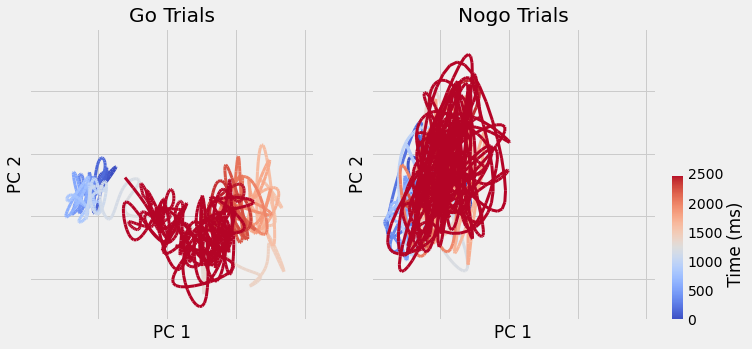

In [57]:
# for motor, correct
print('Motor Correct Trials')
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

titles = ['Go Trials', 'Nogo Trials']

# random limits to start with
pc_xlim = [0,0.3]
pc_ylim = [0,0.3]

for i, action in enumerate(actions):
    traj_viz_continous(pc_motor_correct[action][0], pc_motor_correct[action][1], 
                       axs[i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)

add_colorbar(axs[1], len(pc_motor_correct[action][0]))

<IPython.core.display.Javascript object>


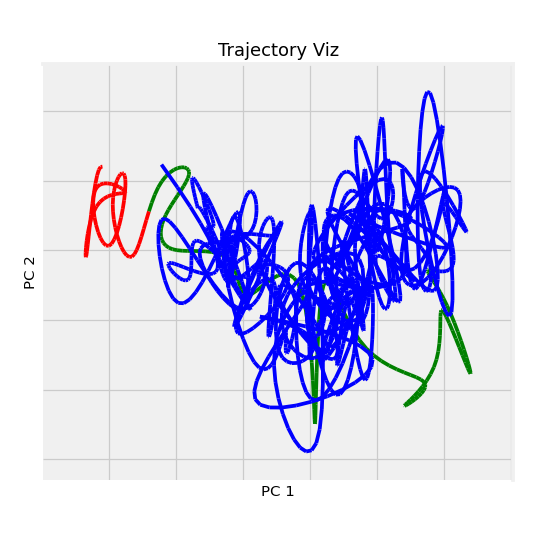

In [113]:
pc_m01 = pc_motor_correct['GO_TRIALS'][0][500:]
pc_m02 = pc_motor_correct['GO_TRIALS'][1][500:]
traj_viz_discrete(pc_m01, pc_m02, vision_idx - 500, action_idx - 500, name_x = 'PC 1', name_y = 'PC 2')

Motor Incorrect Trials


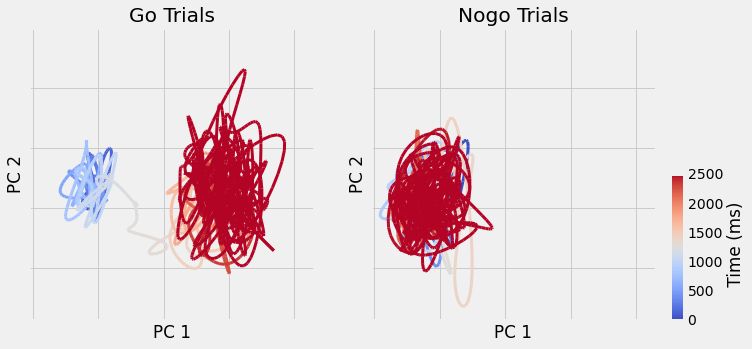

In [58]:
# for motor, incorrect
print('Motor Incorrect Trials')
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

titles = ['Go Trials', 'Nogo Trials']

# random limits to start with
pc_xlim = [0,0.3]
pc_ylim = [0,0.3]

for i, action in enumerate(actions):
    traj_viz_continous(pc_motor_incorrect[action][0], pc_motor_incorrect[action][1], 
                       axs[i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)

add_colorbar(axs[1], len(pc_motor_incorrect[action][0]))

Visualize TSNE results. Not important. 

Vision Correct Trials
Vision Incorrect Trials


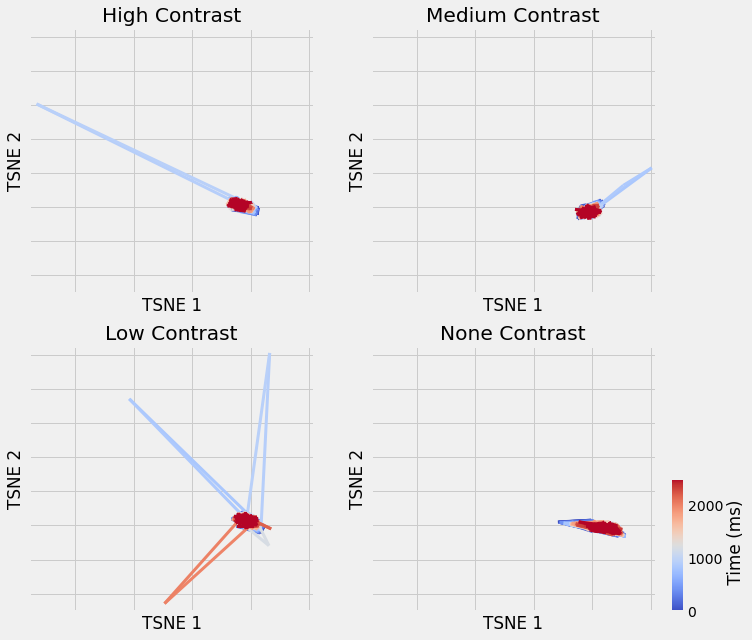

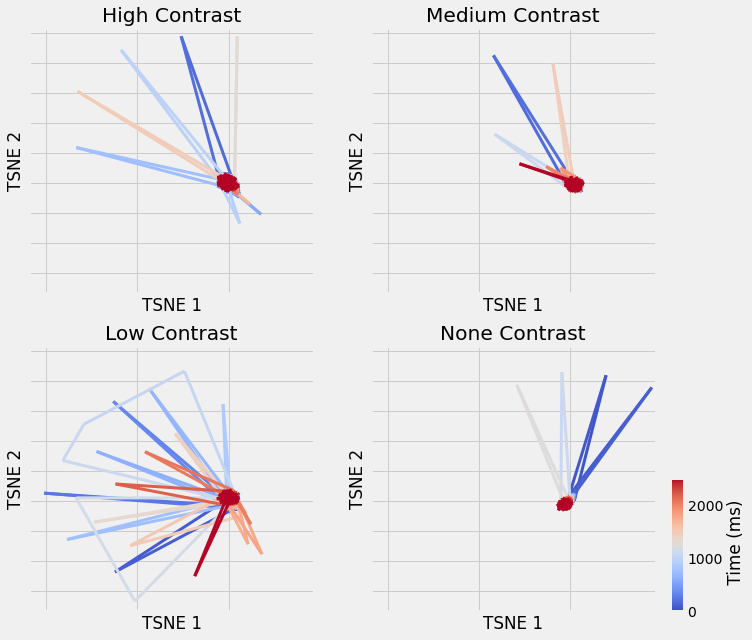

In [44]:
# Visualization for vision, correct
print('Vision Correct Trials')
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

pc_indicse = [ 5, 6]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(embed_correct[contrast][:, 0], embed_correct[contrast][:, 1], 
                       axs[i//2, i%2], 
                       name_x = 'TSNE 1', name_y = 'TSNE 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_correct[contrast][0]))


fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

pc_indicse = [ 5, 6]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(embed_incorrect[contrast][:, 0], embed_incorrect[contrast][:, 1], 
                       axs[i//2, i%2], 
                       name_x = 'TSNE 1', name_y = 'TSNE 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_correct[contrast][0]))
# Visualization for vision, correct
print('Vision Incorrect Trials')